# Clean data

## Step 1

1. Transpose data so routes are stored in rows 
2. Remove all columns aside from grade and holds  
3. Remove route 304387 as it includes an invalid handhold


In [25]:
import pandas as pd
#load data
data2016 = pd.read_json("raw/moonboard_problems_setup_2016.json")
#transpose data
data2016 = data2016.transpose()

print("Size of Data")
print(data2016.shape)
print(data2016.iloc[0])

#generate a copy for future reference
copy_data2016 = data2016.copy(deep=True)

#drop unecessary data
data2016 = data2016.drop(columns=['Method', 'Name', 'MoonBoardConfigurationId', 'Setter',
       'Rating', 'Repeats', 'Holdsetup', 'IsBenchmark', 'IsAssessmentProblem', 'DateInserted'])

print("-------")
print(data2016.loc[304387]["Moves"]) #hold A6 is illegally in this route
data2016.drop(304387,inplace=True)


Size of Data
(25907, 12)
Method                                                      Feet follow hands
Name                                                         OFF THE MATTRESS
Grade                                                                     8A+
MoonBoardConfigurationId                                                    0
Setter                      {'Nickname': 'bcy', 'Firstname': 'Bocheng', 'L...
Rating                                                                      0
Repeats                                                                     0
Holdsetup                   {'Id': 1, 'Description': 'MoonBoard 2016', 'Ho...
IsBenchmark                                                             False
IsAssessmentProblem                                                     False
Moves                       [{'Id': 1910055, 'Description': 'K18', 'IsStar...
DateInserted                                            /Date(1554298797933)/
Name: 341208, dtype: object
-------
[{'

## Step 2

1. Convert *Moves* Col into 3 arrays of 18x11
2. Check for duplicates
3. Show a frequency graph to get an idea of the dataset

The climbing wall
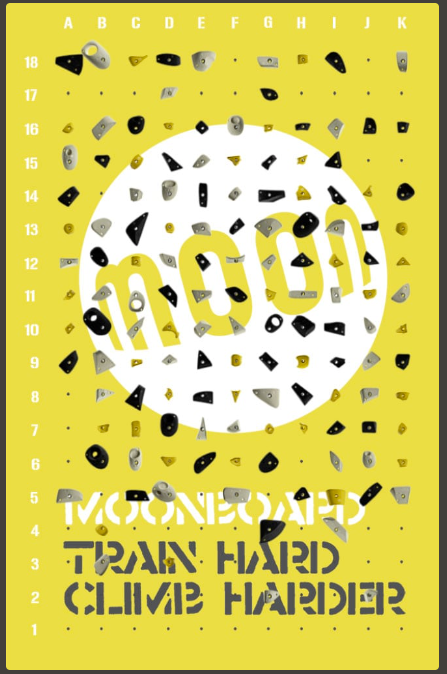

In [26]:
import numpy as np

def convert_key(key):
    '''
    Converts desciption (e.g B10) into a row and column index
    for a 18x11 array
    '''
    letter = key[0]
    number = key[1:]
    
    col = ord(letter) - 65
    row = 18-int(number)

    return row,col

def convert_moves(moves):
    '''
    Converts the list of dictionarys from the moves column into
    3 18x11 arrays for start/middle/end holds
    '''
    holds = np.zeros((3,18,11),dtype=bool)

    
    for dic in moves:
        key = dic['Description']
        
        row,col = convert_key(key)
        if dic['IsStart']:
            holds[0,row,col] = True
        elif dic['IsEnd']:
            holds[2,row,col] = True
        else:
            holds[1,row,col] = True
            
    return holds


data2016["Moves"] = data2016["Moves"].apply(convert_moves)

In [3]:
#we end up with the list duplicates of pairwise duplicates
#this process can take 20+ minutes so we have saves the duplicates as a .npy file

all_moves = []

def dup(all_moves,move):
    for m in all_moves:
        if (m[0] == move).all():
            return True,m[1]
        
    return False,_

duplicates = []

for i,line in data2016.iterrows():
    isdup,k = dup(all_moves,line["Moves"])
    if isdup:
        print(i,k,line["Grade"],copy_data2016.loc[k]["Grade"],copy_data2016.loc[i]["Name"],copy_data2016.loc[k]["Name"])
        duplicates.append((i,k))
    else:
        all_moves.append((line["Moves"],i))
        
print('Finished finding duplicates')

339300 339301 7A+ 7A+ JACK REACHER JACK REACHER
338209 338210 6B+ 6B+ MEG1 MEG1
330643 330644 6B+ 6B+ SON OF KRYPTON SON OF KRYPTON
326007 326008 7B 7B RECEPÇÃO RECEPÇÃO
325820 325821 7A+ 7A+ BEST KEPT SECRET BEST KEPT SECRET
323993 323994 6B+ 6B+ ELY ELY
323805 323806 6B+ 6B+ NOT MINE NOT MINE
323804 323806 6B+ 6B+ NOT MINE NOT MINE
321997 321998 6B+ 6B+ DIONYSUS DIONYSUS
314432 314433 6C 6C BZ - WALKING ON THE MOON BZ - WALKING ON THE MOON
313869 313870 7A 7A THE LAST BIG BANG THE LAST BIG BANG
313610 313611 7B 7B YUMMI! YUMMI!
312479 312480 7C 7C DANG MAGIC DANG MAGIC
310477 310478 7B 7B SNIKERS SNIKERS
308838 308839 6C 7A RACHEL RACHEL’S PROBLEM
306036 306037 6B+ 6B+ ЛЕГХКАЯ ПРОБЛЕМА ЛЕГХКАЯ ПРОБЛЕМА
305590 305591 6B+ 6B+ ВСЁ СНАЧАЛА№2 ВСЁ СНАЧАЛА№2
295942 295946 7C 7C JARLZ YARLAMAGNE
286817 286818 7A 7A DON’T TRY THAT CLIMB DON’T TRY THAT CLIMB
285167 287287 7A 7A SUPER! ST. ELMO'S FIRE
281999 282001 6B+ 6B+ SOMETHING TO WARM UP SOMETHING TO WARM UP
278472 278474 6B+ 6B+ FRANK TH

In [9]:
np.save('2016Duplicates.npy',duplicates)

In [27]:
duplicates = np.load('2016Duplicates.npy')
issues = []

for i,j in duplicates:
    if data2016.loc[i]["Grade"] == data2016.loc[j]["Grade"]:
        data2016.drop(i,inplace=True)
    else:
        issues.append((i,j))
        

for pair in issues:
    print(pair)

(308838, 308839)
(254067, 269201)
(235880, 263369)
(233871, 237343)
(190389, 276317)
(184714, 253376)
(184295, 283540)
(135425, 146578)
(83277, 124727)
(67138, 70051)
(44828, 114054)
(44584, 252606)
(24826, 174872)
(21810, 78276)
(20038, 52770)
(19224, 271465)


In [28]:
# we can see from the printed pairs above all of them are independent
# so we can drop either i or j depending on which one was repeated less
for i,j in issues:
    if copy_data2016.loc[i]["Repeats"] < copy_data2016.loc[j]["Repeats"]:
        data2016.drop(i,inplace=True)
    else:
        data2016.drop(j,inplace=True)
        
data2016.shape

(25841, 2)

Text(0.5, 1.0, 'End Holds')

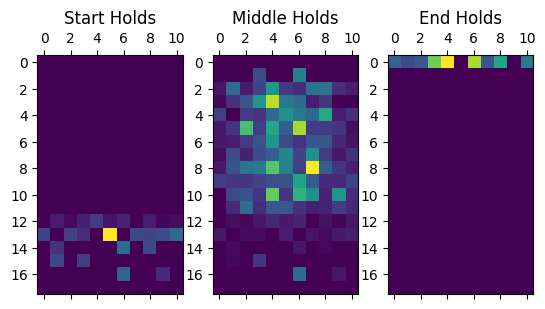

In [29]:
import matplotlib.pyplot as plt




freq = sum(data2016["Moves"])

figure, axis = plt.subplots(1,3)

axis[0].matshow(freq[0])
axis[0].set_title('Start Holds')
axis[1].matshow(freq[1])
axis[1].set_title('Middle Holds')
axis[2].matshow(freq[2])
axis[2].set_title('End Holds')



In [30]:
#save the final dataset
data2016.to_pickle("2016dataclean.pkl")

## Step 3
(note: the dataset has now been reduced from 25907 to 25841 routes)

1. Create a new dataframe that is ready to be used a training data
2. We know that some holds are never used on the moonboard such as A1 so we will reduce the size of the *moves* arrays by flattening and decreasing the size of the arrays
3. Relabel the grades as an integer scale

In [32]:
training_data = pd.read_pickle("2016dataclean.pkl")
training_data.head

<bound method NDFrame.head of        Grade                                              Moves
341208   8A+  [[[False, False, False, False, False, False, F...
341206   6B+  [[[False, False, False, False, False, False, F...
341205   6B+  [[[False, False, False, False, False, False, F...
341204   6B+  [[[False, False, False, False, False, False, F...
341199    6C  [[[False, False, False, False, False, False, F...
...      ...                                                ...
19219     7A  [[[False, False, False, False, False, False, F...
19218     7A  [[[False, False, False, False, False, False, F...
19217    6B+  [[[False, False, False, False, False, False, F...
19216    6B+  [[[False, False, False, False, False, False, F...
19215    6B+  [[[False, False, False, False, False, False, F...

[25841 rows x 2 columns]>

# --------------OLD PROCESSES-----------------

In [ ]:
empty_holds = ["F18",
              "J18",
              "A17","B17","C17","E17","F17","H17","I17","J17","K17",
              "J15","K15",
              "B14",
              "A8",
              "A7",
              "A6","H6",
              "B5","E5","G5",
              "A4","C4","D4","E4","F4","H4","J4","K4",
              "A3","C3","E3","F3","G3","H3","I3","J3","K3",
              "A2","B2","C2","D2","E2","F2","H2","I2","K2",
              "A1","B1","C1","D1","E1","F1","G1","H1","I1","J1","K1",]